# Applying the ResNet-50 to scaleograms as in Daydulo et al. 2022

[Daydulo et al. 2022](https://doi.org/10.1186/s12911-022-02068-1) - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study.

Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. The Creative Commons Public Domain Dedication waiver (http://creativecommons.org/publicdomain/zero/1.0/) applies to the data made available in this article, unless otherwise stated in a credit line to the data. Reprints and Permissions

## About ResNet-50

ResNet-50 is a 50 layer Residual network. It is a pre-trained convolutional neural network for image classification and computer vision. The 50 layers include 48 convolution layers, 1 average pool layer, and 1 max pooling layer.

Implementation of ResNet-50 in this notebook was based on the following article: https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351

## Set up - import packages and set up environment for reproducible results

**Note:** The steps to enable reproducibility work at a low number of epochs (e.g. 4) but results do still start to differ between runs after a while.

We have to set PYTHONHASHSEED *before* importing tensorflow.

In [1]:
import os

# 1. Set PYTHONHASHSEED environment variable to 0
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
# Import the other packages
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

2023-12-06 11:03:59.570880: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 11:03:59.643932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:03:59.643982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:03:59.644023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:03:59.656882: I tensorflow/core/platform/cpu_feature_g

Run the other steps for allowing reproducible results.

This follows the [Keras tutorial](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) and these stack overflow posts [[1]](https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds), [[2]](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras), on getting reproducible results during development.

In [3]:
def reset_seeds():
    '''
    Set the pseudo-random generators of python, numpy and tensorflow
    It is is important to call this function everytime before running the model
    '''
    random.seed(123)
    np.random.seed(123)
    tf.random.set_seed(123)

# 2. Set random seeds
reset_seeds()

# 3. Configure a new global tensorflow session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-12-06 11:04:03.151829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:04:03.161167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:04:03.161441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## First stage

### Import training, validation and test sets

Daydulo et al. 2022 state that they use a mini batch size of 30, with image size of 224 x 224 x 3.

In [4]:
# Define image size
height = 224
width = 224

In [5]:
# Import the training set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/train/',
    image_size=(height,width), # Resize the images
    batch_size=30)

Found 629 files belonging to 2 classes.


2023-12-06 11:04:04.106300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:04:04.106625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:04:04.106807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Import the validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/validation/',
    image_size=(height,width),
    batch_size=30)

Found 71 files belonging to 2 classes.


In [7]:
# Import the test set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/test/',
    labels='inferred',
    image_size=(height, width),
    batch_size=30)

Found 78 files belonging to 2 classes.


In [8]:
# View the class names
train_set.class_names

['class_0_normal', 'class_1_distressed']

### Build the deep learning model

Implementation of ResNet50 in Python is based on [this tutorial](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351).

Set up the ResNet-50 model.

In Daydulo et al. 2022:
* Input shape 224 x 224 x 3
* Not certain if imagenet weights were used

Architecture of the model:
* 7x7 conv 64 stride
* 3x3 max pool stride
* Stage 1: 1x1 conv 64, 3x3 conv 64, 1x1 conv 256
* Stage 2
* Stage 3
* Stage 4
* Classifier: Average pooling, then fully connected 1000

This description appears to be the same as the standard description of a ResNet50 model, as in the second image below.

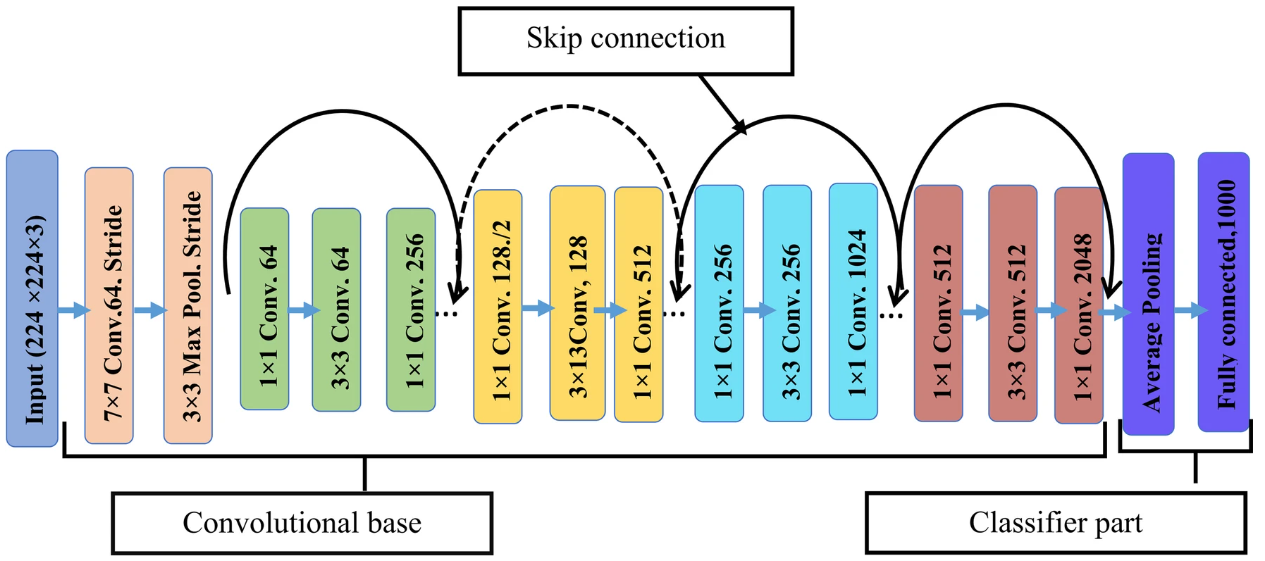

In [9]:
Image.open('images/daydulo_figure8.png')

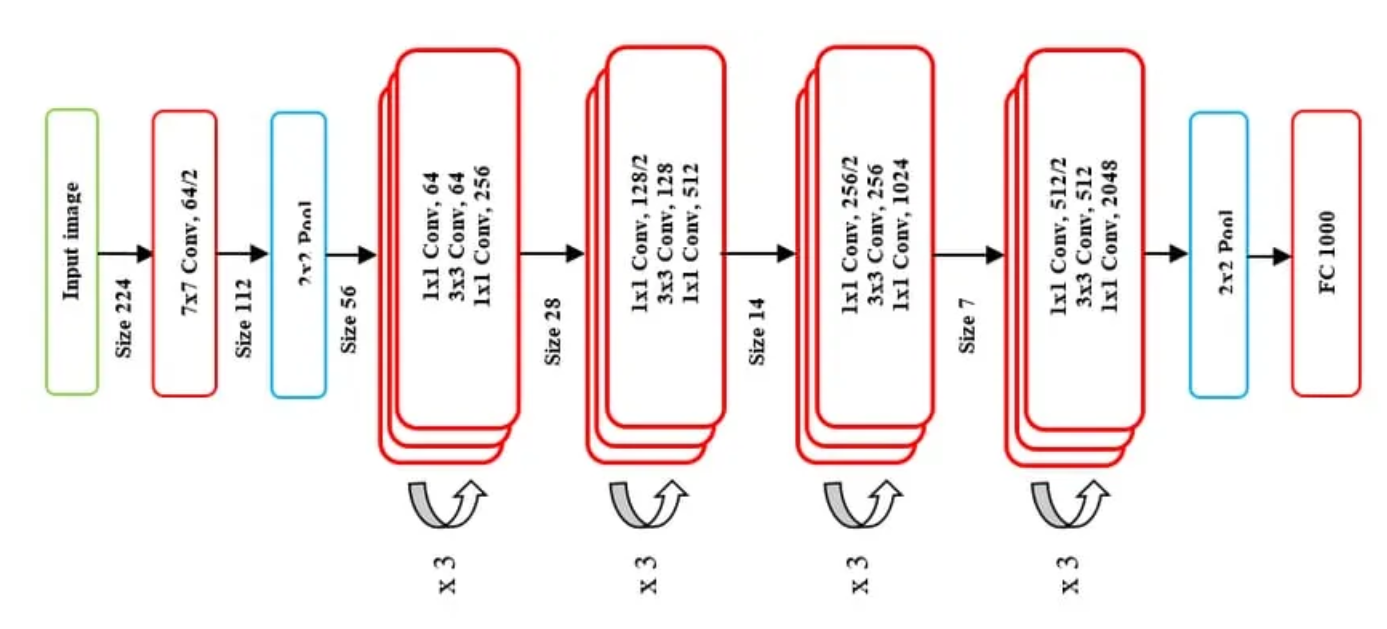

In [10]:
Image.open('images/resnet50_architecture_tds.png')
# Source: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758

In [11]:
# Reset seeds
reset_seeds()

# Initialise TensorFlow Sequential model
dnn_model = keras.Sequential()

# Import the pre-train ResNet50 model
imported_model= tf.keras.applications.ResNet50(
    include_top=False, # Ensures we can add custom input and output layers
    input_shape=(height, width, 3),
    pooling='avg', # Applies global average pooling to the output of the last convolutional block
    weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False # Ensures the parameters and weights are not trained again to speed up training process

# Add ResNet50
dnn_model.add(imported_model)

# Add fully connected layer where output is 2 units and activation function is
# softmax. Since it's binary, I think using softmax is the same as using sigmoid?
dnn_model.add(layers.Dense(units=2, activation='softmax'))

# View a summary of the model
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Compile the model.

Daydulo et al. 2022 parameters:
* State that they use an Adam optimiser with learning rate 0.001
* Can see from their training and validation curves that they use accuracy and loss to evaluate model performance
* They do not state how they calculate loss, but the [MATLAB deep learning documentation](https://uk.mathworks.com/help/deeplearning/ug/monitor-deep-learning-training-progress.html) states that if the final layer of a network is a classification layer, then the loss function is the cross entropy loss

In [12]:
dnn_model.compile(
    optimizer=Adam(learning_rate=0.001), # will improve performance and accuracy, and handle and debug errors in training
    loss='sparse_categorical_crossentropy', # how we calculate errors during training
    metrics=['accuracy']) # how we evaluate model performance after each training cycle (epoch)

Fit the compiled model with the training and validation set.

In Daydulo et al. 2022:
* They state their validation frequency set is 15 iterations.
* They state that they use validation frequency 20 iteration.
* Their figures show that there were apx. 800 iterations.

As 800 iterations would take a very long time to run, I have tried it with 100 iterations.

In [13]:
history = dnn_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=100)

Epoch 1/100


2023-12-06 11:04:14.732595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-06 11:04:17.359503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f80d80127a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 11:04:17.359553: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-06 11:04:17.370022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 11:04:17.518904: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 14s 314ms/step - loss: 1.0771 - accuracy: 0.4960 - val_loss: 0.9458 - val_accuracy: 0.5634
Epoch 2/100
21/21 [==============================] - 3s 136ms/step - loss: 0.7398 - accuracy: 0.5374 - val_loss: 0.8216 - val_accuracy: 0.5352
Epoch 3/100
21/21 [==============================] - 3s 135ms/step - loss: 0.7189 - accuracy: 0.5707 - val_loss: 0.7459 - val_accuracy: 0.4789
Epoch 4/100
21/21 [==============================] - 3s 136ms/step - loss: 0.6628 - accuracy: 0.5978 - val_loss: 0.7026 - val_accuracy: 0.5211
Epoch 5/100
21/21 [==============================] - 3s 131ms/step - loss: 0.6503 - accuracy: 0.6010 - val_loss: 0.7042 - val_accuracy: 0.5211
Epoch 6/100
21/21 [==============================] - 3s 131ms/step - loss: 0.6675 - accuracy: 0.5803 - val_loss: 0.6898 - val_accuracy: 0.5352
Epoch 7/100
21/21 [==============================] - 3s 133ms/step - loss: 0.6435 - accuracy: 0.6471 - val_loss: 0.6834 - val_accuracy: 0.5352
Epoch 8/10

Plot the training and validation curves

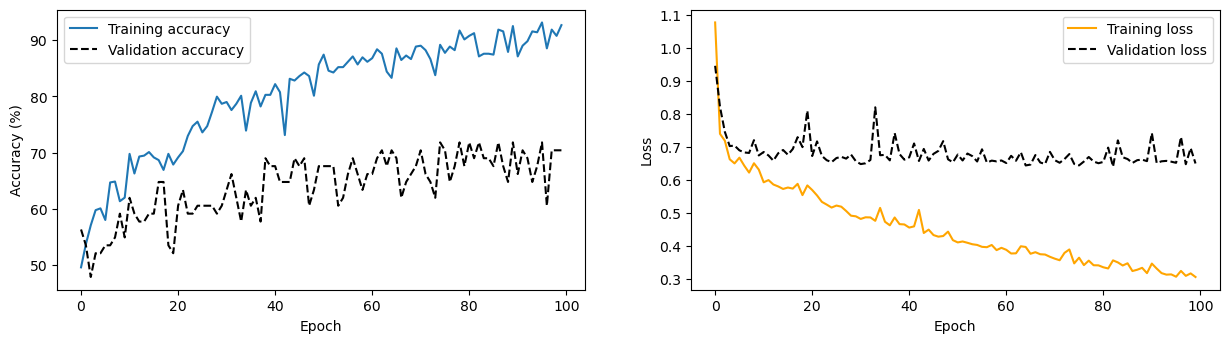

In [14]:
plt.figure(figsize = (15, 8))

# Plot the training and validation accuracy as a percentage
plt.subplot(221)
plt.plot([i*100 for i in history.history['accuracy']])
plt.plot([i*100 for i in history.history['val_accuracy']],
         linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training accuracy', 'Validation accuracy'])

# Plot the training and validation loss
plt.subplot(222)
plt.plot(history.history['loss'], color='orange')
plt.plot(history.history['val_loss'], linestyle='--', color='black')
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Training loss', 'Validation loss']) 

plt.show()

Comparisons to the paper:
* Reachs training accuracy much quicker (as only did 100 epochs), but that diverges from validation accuracy.
* Not certain that ResNet-50 parameters are definietely all the same as can only go in information found in their paper, do not have their code
* There were slight differences in my images due to the scale range determined by ssqueezepy

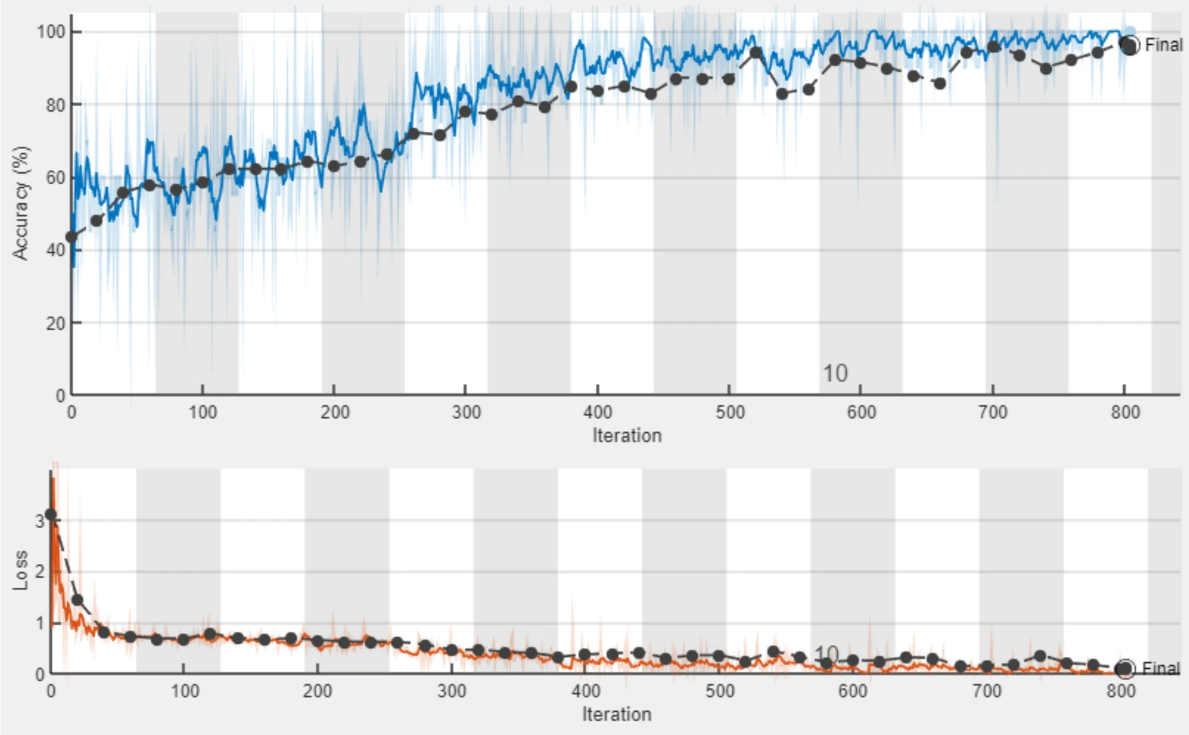

In [15]:
Image.open('images/daydulo_figure9a.png')

### Test the model (using the test set)

In [16]:
# You can access the data and classifications from the test_set like so
# See how the batch_size of 30 means we will predict in 3 epochs
for image, image_class in test_set:
    print(image_class.numpy())

[1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]
[1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0]
[1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1]


Make predictions for images in test set.

In [17]:
predictions = []
labels = []
for images, classes in test_set:
    # Make predictions for the images, and find class based on max probability
    probabilities = dnn_model.predict(images)
    predicted_classes = np.argmax(probabilities, axis=1)
    predictions = np.concatenate([predictions, predicted_classes])

    # Save those image classes
    labels = np.concatenate([labels, classes.numpy()])

1/1 [==============================] - 1s 1s/step


Replace 0 and 1 with the classes normal and distressed.

In [18]:
map_classes = {0: 'normal', 1: 'distressed'}
pred_classes = pd.Series(predictions).map(map_classes).to_list()
label_classes = pd.Series(labels).map(map_classes).to_list()

Produce confusion matrix

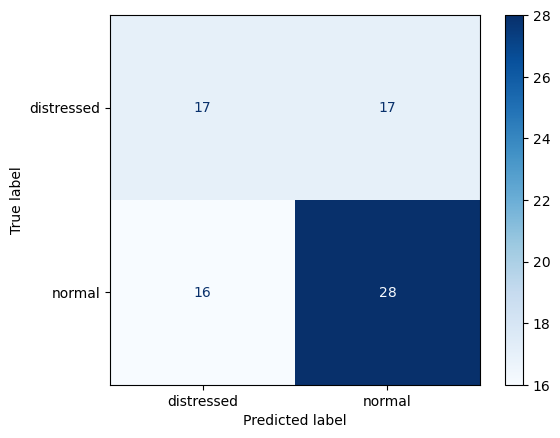

In [19]:
# Set CM label order
cm_labels = ['distressed', 'normal']

# Produce confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true = label_classes,
    y_pred = pred_classes,
    labels = cm_labels, # Set display order
    cmap = 'Blues'
)

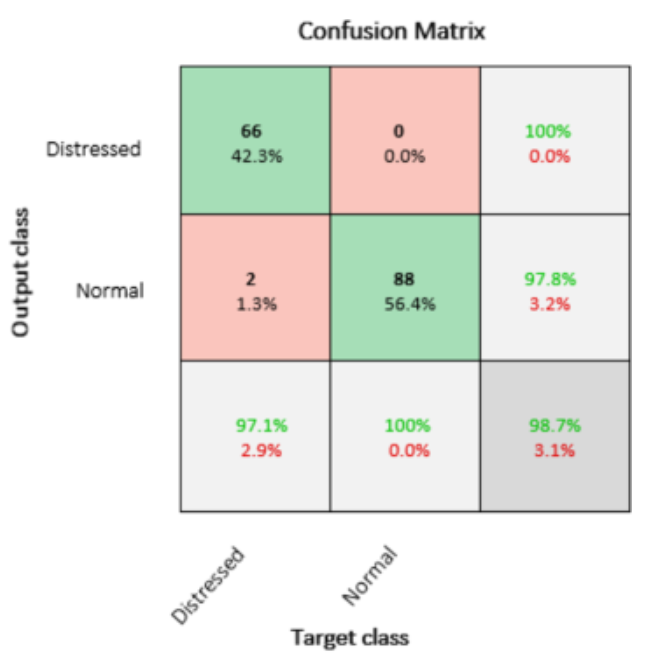

In [20]:
Image.open('images/daydulo_table1a.png')